In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import datetime

from sklearn.linear_model import LinearRegression

from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
from statsmodels.formula.api import ols
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm


import arch
from arch import arch_model

import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yfin
yfin.pdr_override()


import warnings

In [2]:
pd.set_option('display.float_format', lambda x: f'{x:,.6f}')
plt.rcParams["figure.figsize"] = (10,6)

#sk.set_config(display='diagram')
warnings.filterwarnings("ignore")

# Assignment

1. Create a time series for an asset in your portfolio, one which exhibits heteroskedasticity, over a period of the previous year based on end of day closing price.
2. Implement an ARCH/GARCH model in Python (or another language of your choosing)
3. Apply the model to the time series that you have created and use it to model the asset risk for the next 10 market days
4. Post your results here and summarize them on a discussion board thread.
5. Upload you code and libraries to the GitHub classroom

## Variables

In [3]:
start = datetime.datetime(2022, 10, 1)
split_date = datetime.datetime(2023,8,24)
#today = datetime.datetime.today()
today = datetime.datetime(2023,10,20)

sp_list = ['ARKK','EXAS','NVTA','PATH','TWLO']

## Functions

In [4]:
def ad_fuller(timeseries):
    print ('Dickey-Fuller Test indicates:')
    df_test = adfuller(timeseries, regression='ct', autolag='AIC')
    output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print(output)

# Load Data

In [5]:
df = pdr.get_data_yahoo(sp_list, period='1y')['Close']
df

[*********************100%%**********************]  5 of 5 completed


,ARKK,EXAS,NVTA,PATH,TWLO
Date,,,,,
2022-11-04,35.220001,37.570000,2.460000,10.790000,42.740002
2022-11-07,34.990002,38.160000,2.400000,11.010000,45.680000
2022-11-08,34.849998,40.910000,2.350000,11.270000,44.459999
2022-11-09,32.570000,40.259998,2.280000,10.550000,43.599998
2022-11-10,37.299999,43.959999,3.110000,11.870000,50.709999
...,...,...,...,...,...
2023-10-30,34.290001,59.060001,0.608000,15.080000,50.410000
2023-10-31,35.080002,61.590000,0.606000,15.530000,51.259998
2023-11-01,35.310001,63.520000,0.576000,15.520000,50.490002


In [29]:
percent_df = df.pct_change().dropna()
percent_df.describe()

,ARKK,EXAS,NVTA,PATH,TWLO
count,250.000000,250.000000,250.000000,250.000000,250.000000
mean,0.000953,0.002863,-0.003539,0.002671,0.001544
std,0.028517,0.033828,0.062124,0.039744,0.034998
min,-0.065423,-0.117275,-0.218605,-0.111995,-0.126429
25%,-0.017574,-0.014758,-0.047200,-0.023047,-0.017690
50%,-0.000904,-0.002097,-0.010640,0.002452,-0.001527
75%,0.017485,0.018526,0.032111,0.026765,0.020527
max,0.145226,0.246451,0.364035,0.176229,0.163073


## Graph Stockprice

<b>1. Create a time series for an asset in your portfolio, one which exhibits heteroskedasticity, over a period of the previous year based on end of day closing price.</b>

The first step in the analysis is to create a timeseries graph of a few stocks in the portfolio looking for a stock that exibits heteroscedasticity over the past year. For this analysis I will focus on the following AI stocks:

- ARKK - ARK Innovation ETF
- EXAS - Exact Sciences Corporation 
- NVTA - Invitae Corporation
- PATH - UiPath Inc. 
- TWLO - Twilio Inc.

The percentage change graph for NVTA shows changes in variance across the portfolio timeframe.


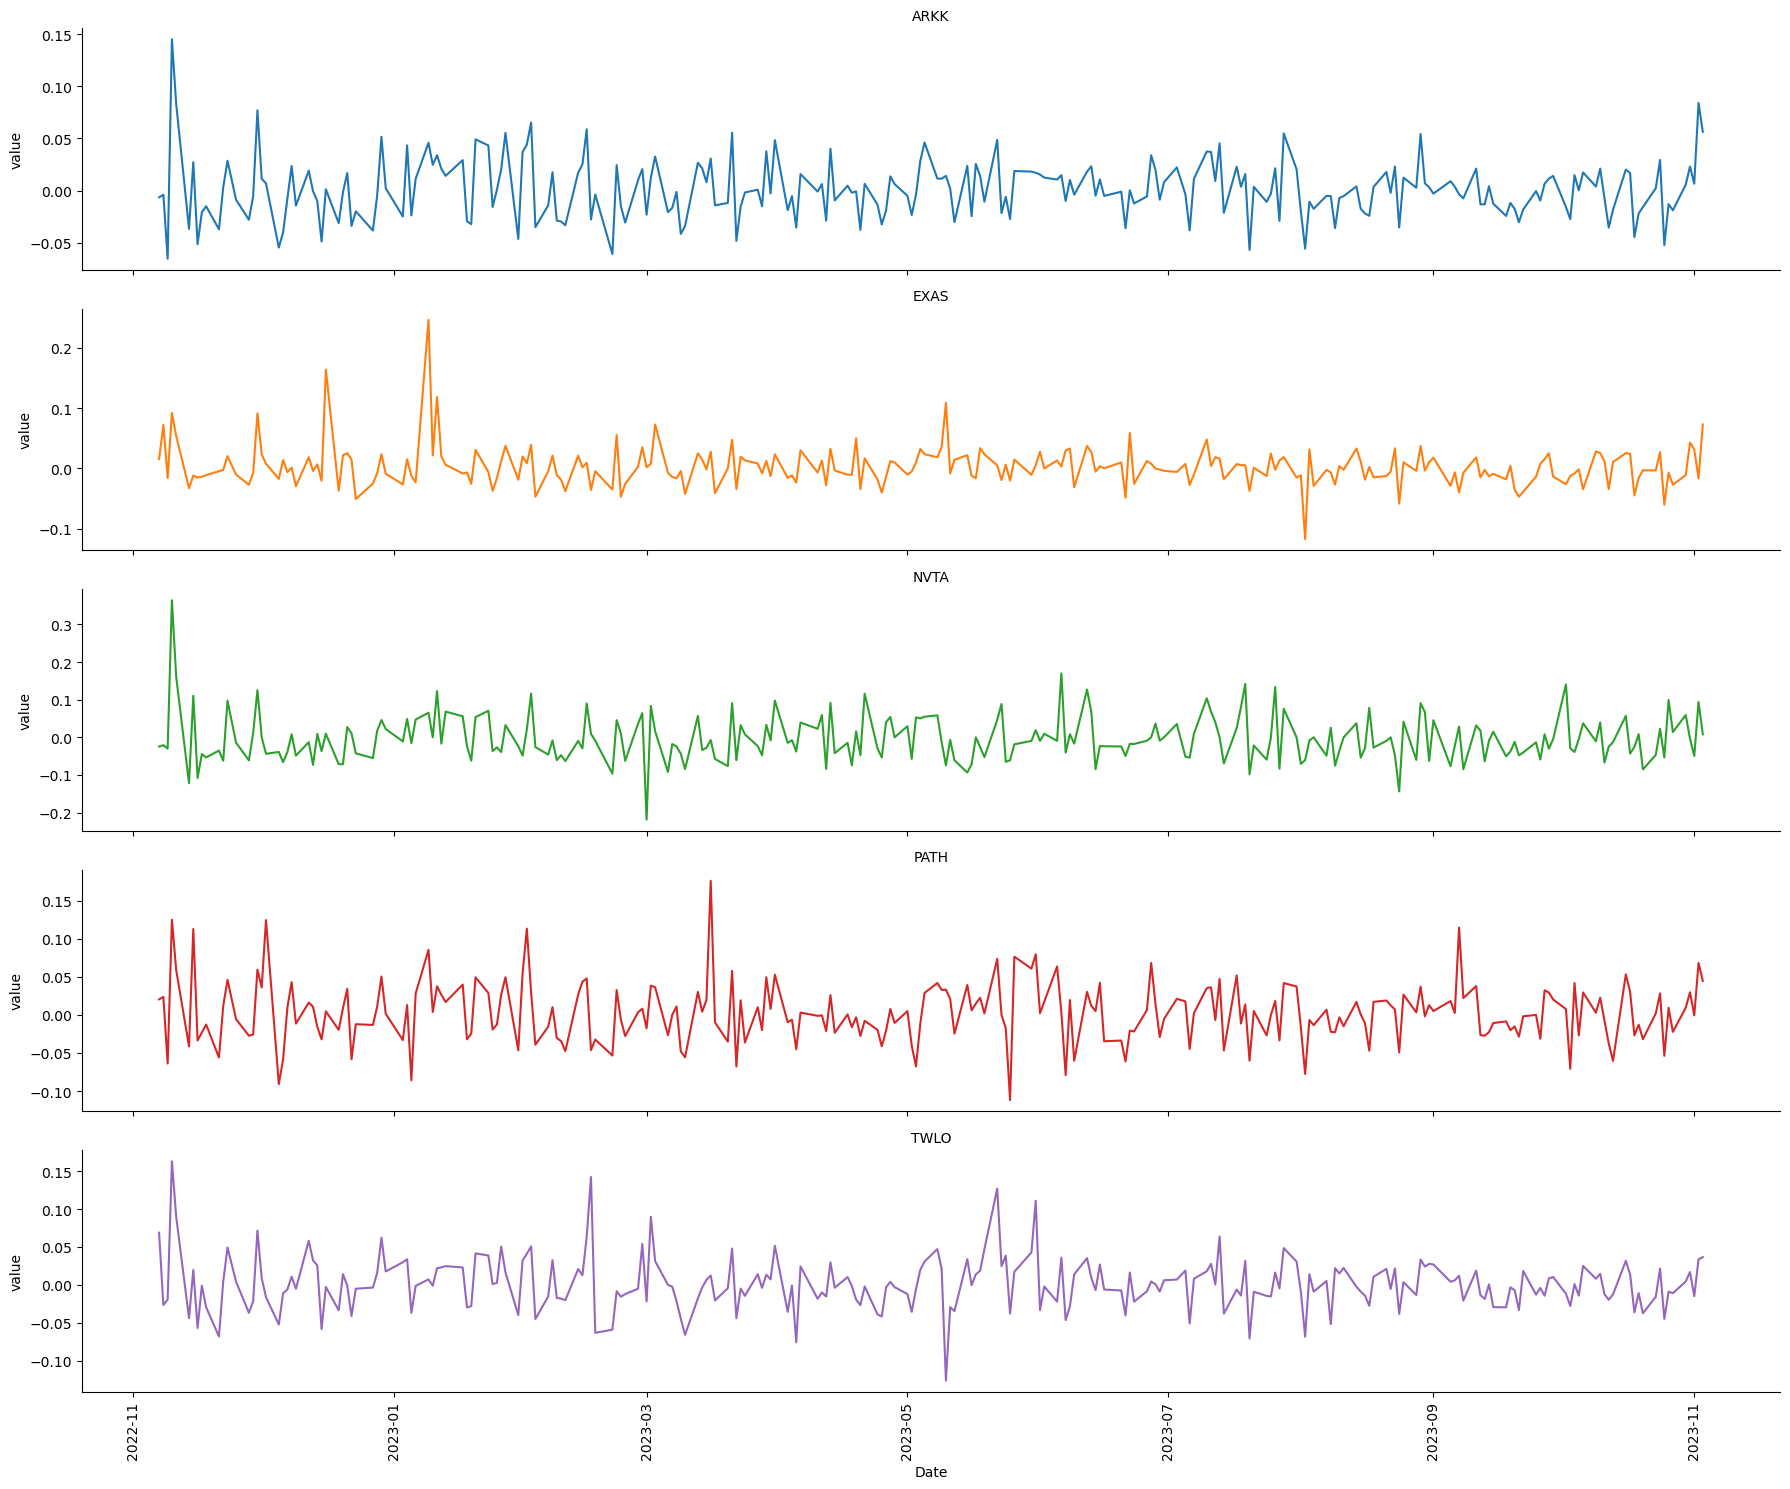

In [7]:
long_df = percent_df.copy()
long_df.reset_index()
long_df.reset_index(inplace=True)
long_df = long_df.melt(id_vars=['Date'])

# Graph
g = sns.FacetGrid(long_df, col='variable', hue='variable',
                  height=3, aspect=6,col_wrap=1, sharey=False)

g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.tick_params(axis='x', labelrotation=90) 
g.tight_layout()
g.map_dataframe(sns.lineplot, y="value", x="Date")

_ = plt.show()


## Augmented Dickey-Fuller Test for Times Stationality

- H0: The time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time.
- HA: The time series is stationary.

The p-value is not less than 0.05 so we fail to reject the Null hypothesis the time series does not have a constant variance

In [8]:
ad_fuller(df['TWLO'])

Dickey-Fuller Test indicates:
Test Statistic                 -1.797500
p-value                         0.705963
#Lags Used                      5.000000
Number of Observations Used   245.000000
dtype: float64


<br>

The returns or the percentage change from the previous day appear to be stationary based on the Dickey-Fuller test.

In [9]:
ad_fuller(percent_df[['TWLO']])

Dickey-Fuller Test indicates:
Test Statistic                 -8.481938
p-value                         0.000000
#Lags Used                      4.000000
Number of Observations Used   245.000000
dtype: float64


# SARIMA Model

Building a SARIMA model for the daily return I start by splitting the data into a training and a testing dataframe. 

- Step 1 prepare the train and test data for the model

In [10]:
splt_index = round(df.shape[0] * 0.8)
train_df = df[:splt_index].copy()
train_df = train_df.asfreq(freq='1d', how='start', method='ffill', fill_value=0)
train_df.fillna(method='ffill', inplace=True)
print('train_df:' , train_df.shape)

train_df: (294, 5)


In [11]:
y_train = train_df[['TWLO']]
y_train
print('y_train:' , y_train.shape)

y_train: (294, 1)


In [12]:
test_df = df[splt_index:].copy()
test_df = test_df.asfreq(freq='1d', how='start', method='ffill', fill_value=0)
test_df.fillna(method='ffill', inplace=True)
test_df
print('test_df:' , test_df.shape)

test_df: (71, 5)


In [13]:
y_test = test_df[['TWLO']]
y_test
print('y_test:' , y_test.shape)

y_test: (71, 1)


- Step 2 - Build the model

In [14]:
s_idx = len(train_df)
e_idx = s_idx + len(test_df) - 1

In [15]:
model = sm.tsa.SARIMAX(y_train)

In [16]:
result_model = model.fit(disp=False)

<br>

The summary of the automated model is a SARIMAX(1,0,0). The automated solution selected a single difference for the stock returns.

In [17]:
result_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   TWLO   No. Observations:                  294
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -593.628
Date:                Sun, 05 Nov 2023   AIC                           1191.257
Time:                        09:40:18   BIC                           1198.624
Sample:                    11-04-2022   HQIC                          1194.207
                         - 08-24-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9994      0.002    624.101      0.000       0.996       1.003
sigma2         3.2460      0.147     22.076      0.000       2.958       3.534
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               317.98
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                             0.65
Prob(H) (two-sided):                  0.47   Kurtosis:                         7.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
train_result = result_model.get_prediction(start=-s_idx, dynamic=False)
train_pred_SARIM = train_result.summary_frame()[1:]
train_pred_SARIM

TWLO,mean,mean_se,mean_ci_lower,mean_ci_upper
Date,,,,
2022-11-05,42.714997,1.801679,39.183771,46.246224
2022-11-06,42.714997,1.801679,39.183771,46.246224
2022-11-07,42.714997,1.801679,39.183771,46.246224
2022-11-08,45.653276,1.801679,42.122050,49.184502
2022-11-09,44.433988,1.801679,40.902762,47.965215
...,...,...,...,...
2023-08-20,59.275303,1.801679,55.744077,62.806529
2023-08-21,59.275303,1.801679,55.744077,62.806529
2023-08-22,60.524572,1.801679,56.993345,64.055798


In [19]:
test_result = result_model.get_prediction(start=s_idx, end=e_idx, dynamic=False)
test_pred_SARIM = test_result.summary_frame()[1:]
test_pred_SARIM

TWLO,mean,mean_se,mean_ci_lower,mean_ci_upper
2023-08-26,59.090799,2.547214,54.098351,64.083246
2023-08-27,59.056229,3.118775,52.943542,65.168915
2023-08-28,59.021679,3.600198,51.965420,66.077937
2023-08-29,58.987149,4.023967,51.100318,66.873980
2023-08-30,58.952639,4.406747,50.315574,67.589705
...,...,...,...,...
2023-10-30,56.885293,14.467166,28.530168,85.240418
2023-10-31,56.852013,14.570522,28.294313,85.409712
2023-11-01,56.818752,14.673031,28.060140,85.577365
2023-11-02,56.785511,14.774710,27.827612,85.743410


<br><br>

The graph of the forcastedr returns.  highlights a 

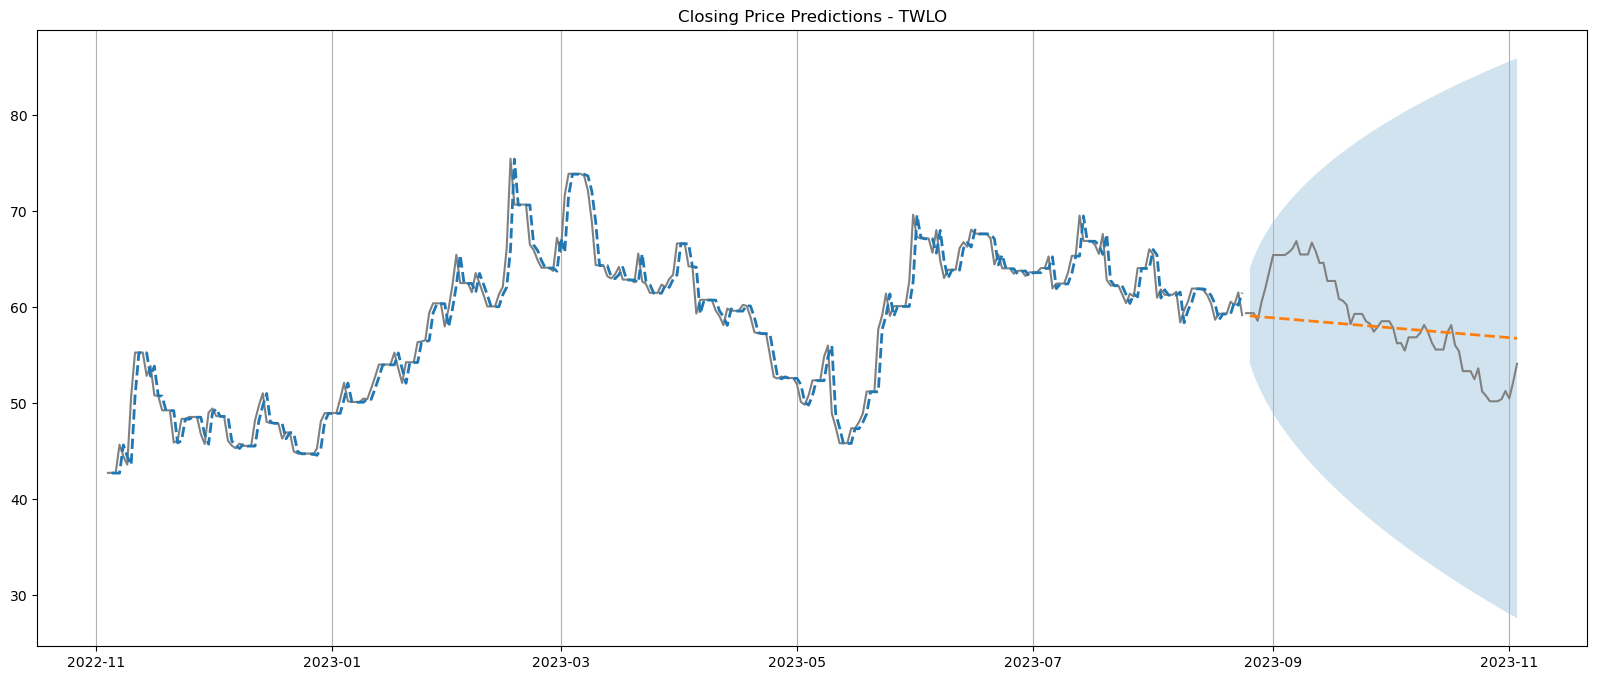

In [20]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(y_train.index, y_train['TWLO'], 'gray')
ax.plot(y_test.index, y_test['TWLO'], 'gray')
ax.plot(train_pred_SARIM.index, train_pred_SARIM['mean'], linestyle='--', linewidth=2)
ax.plot(test_pred_SARIM.index, test_pred_SARIM['mean'], linestyle='--', linewidth=2)
ax.fill_between(test_pred_SARIM.index, test_pred_SARIM['mean_ci_lower'], test_pred_SARIM['mean_ci_upper'], alpha=0.20)

ax.set(title='Closing Price Predictions - TWLO');

# ARCH Model

Next I will create an ARCH model using the returns from TWLO. I used the simple constructor arch_model() for this analysis.

start = datetime.datetime(2022, 10, 1)
split_date = datetime.datetime(2023,8,24)
today = datetime.datetime(2023,10,30)
#today = datetime.datetime.today()

In [91]:
results_df = pd.DataFrame()

In [92]:
stock_df = pdr.get_data_yahoo('TWLO', period='1y')[['Close']]
print('stock_df',stock_df.shape)

[*********************100%%**********************]  1 of 1 completed
stock_df (251, 1)


In [93]:
returns = 100 * stock_df['Close'].pct_change().dropna()
#model = arch_model(returns, vol='Garch', p=1, o=0, q=1, dist='Normal')
model = arch_model(returns, vol='Garch')

res = model.fit(last_obs=split_date)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 118066729.93059102
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1268.761178824813
Iteration:      3,   Func. Count:     20,   Neg. LLF: 541.4525801221077
Iteration:      4,   Func. Count:     26,   Neg. LLF: 544.2005776641981
Iteration:      5,   Func. Count:     32,   Neg. LLF: 540.6203355074066
Iteration:      6,   Func. Count:     38,   Neg. LLF: 540.5925243875413
Iteration:      7,   Func. Count:     44,   Neg. LLF: 540.5876681119696
Iteration:      8,   Func. Count:     48,   Neg. LLF: 540.5876681124317
Optimization terminated successfully    (Exit mode 0)
            Current function value: 540.5876681119696
            Iterations: 8
            Function evaluations: 48
            Gradient evaluations: 8


<br>

## ARCH Model Summary

The summary for the Generalized Autoregressive Conditional Heteroskedasticity (GARCH) model is presented below. The R-squared and Adj R-squared are 0 but it 
is important to note that the concept of R-squared and Adj R-squared does not directly apply to GARCH models, as it is commonly used in linear regression models. 

- MU - However, the p-value for MU is greater than the significance level of 0.05, so we will fail to reject the null hypothesis for MU and assume it is equal to 0. The average returns in the time series include 0 in the 95% confidence range, so we can conclude that the return of the time series is not significantly different from zero. 
- Omega - the p-value suggests that there is a baseline volatility level for returns 1.3374
- Alpha - based on the p-value, is not statistically significant. The auto-regressive component of the returns does not influence the current variance
- Beta - is statistically significant based on the p-value. The moving average component of the returns does influence the current variance.

In [94]:
print(res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -540.588
Distribution:                  Normal   AIC:                           1089.18
Method:            Maximum Likelihood   BIC:                           1102.35
                                        No. Observations:                  199
Date:                Sun, Nov 05 2023   Df Residuals:                      198
Time:                        13:39:22   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1751      0.258      0.680      0.497 [ -0.330,  0.68

<br>

The standard diagnostic plots for the GARCH model show decreasing annualized conditional volatility and residual plot that appears to be stationary.

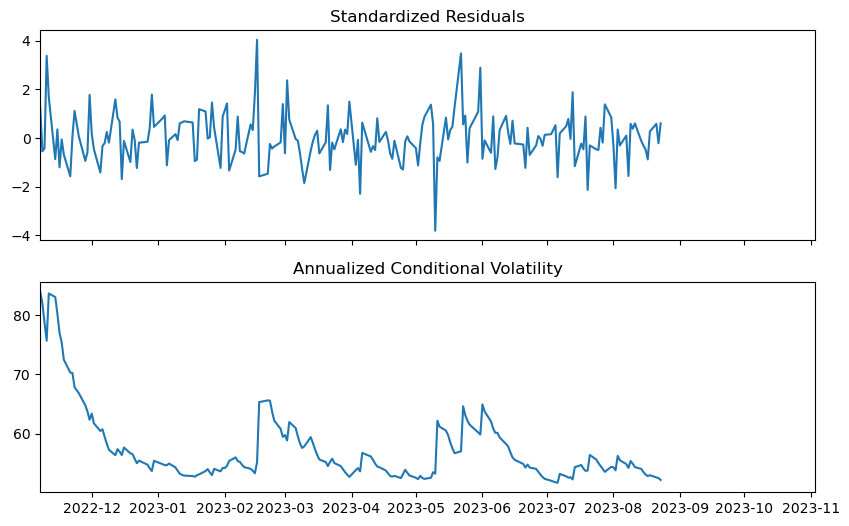

In [95]:
fig = res.plot(annualize='D')
plt.show()

<br>

The 

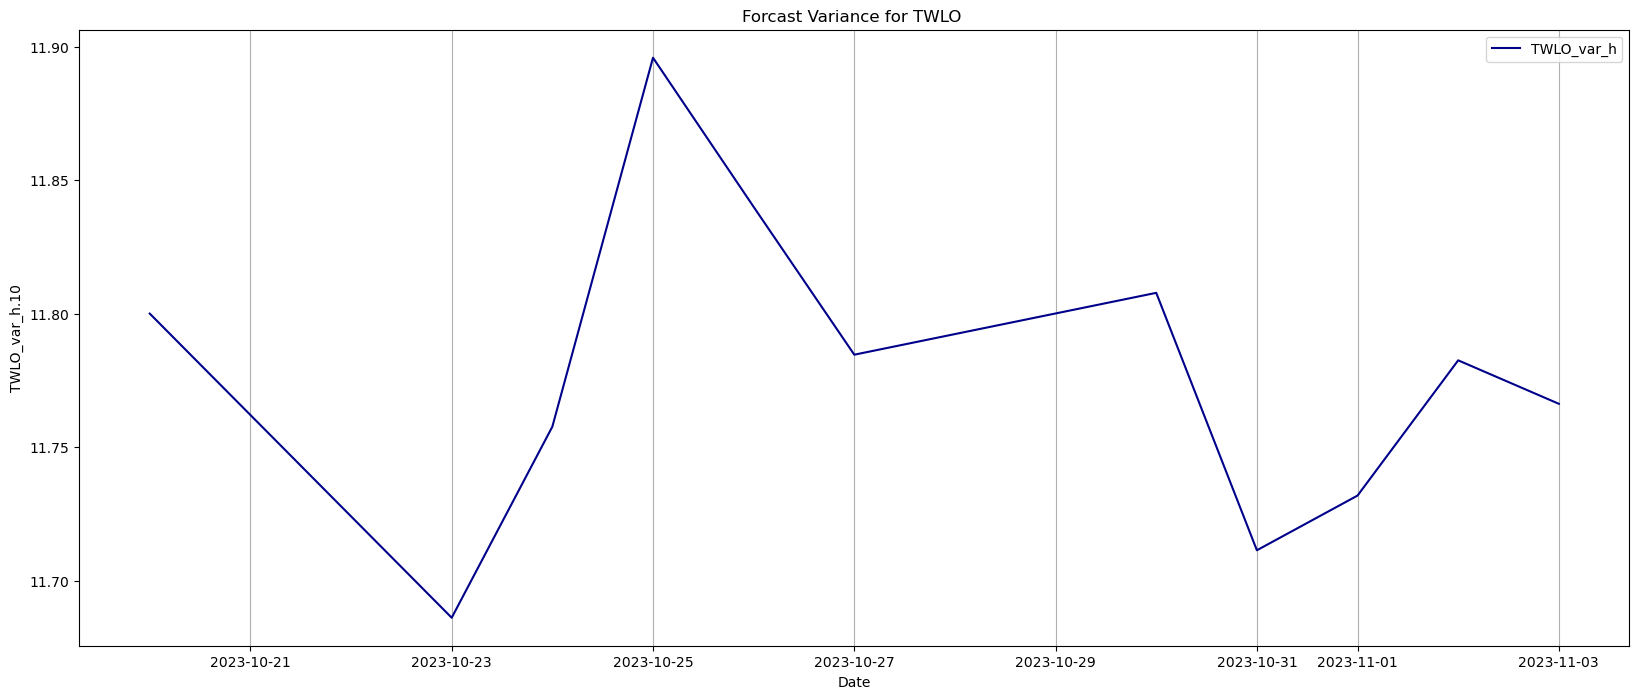

In [96]:
# Forecasting
forecasts = res.forecast(horizon=10, start=today, method='simulation')
results_df['TWLO_var_h.10'] = forecasts.variance[today:]['h.10']
results_df['TWLO_mean_h.10'] = forecasts.mean[today:]['h.10']

# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()
g = sns.lineplot(x = 'Date', y = 'TWLO_var_h.10', data=results_df, label='TWLO_var_h', color='darkblue')
#g = sns.lineplot(x = 'Date', y = 'TWLO_mean_h.10', data=results_df, label='TWLO_mean_h', color='green')
plt.ticklabel_format(style='plain', axis='y')
ax.set(title='Forcast Variance for TWLO ');

In [97]:
res

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -540.588
Distribution:                  Normal   AIC:                           1089.18
Method:            Maximum Likelihood   BIC:                           1102.35
                                        No. Observations:                  199
Date:                Sun, Nov 05 2023   Df Residuals:                      198
Time:                        13:39:22   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1751      0.258      0.680      0.497 [ -0.330,  0.68

# Long 
long_df = forecasts.variance[today:]
long_df.reset_index(inplace=True)
long_df = long_df.melt(id_vars=['Date'])
print('long_df:', long_df.shape)

# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

g = sns.lineplot(x = 'Date', y = 'value', data=long_df, hue='variable')
#g.set(xlim = (30,32))
plt.ticklabel_format(style='plain', axis='y')
ax.set(title='Forcast Variance fro ');

forecasts = res.forecast(horizon=10, start=split_date, method='simulation')
print(forecasts.variance.tail())

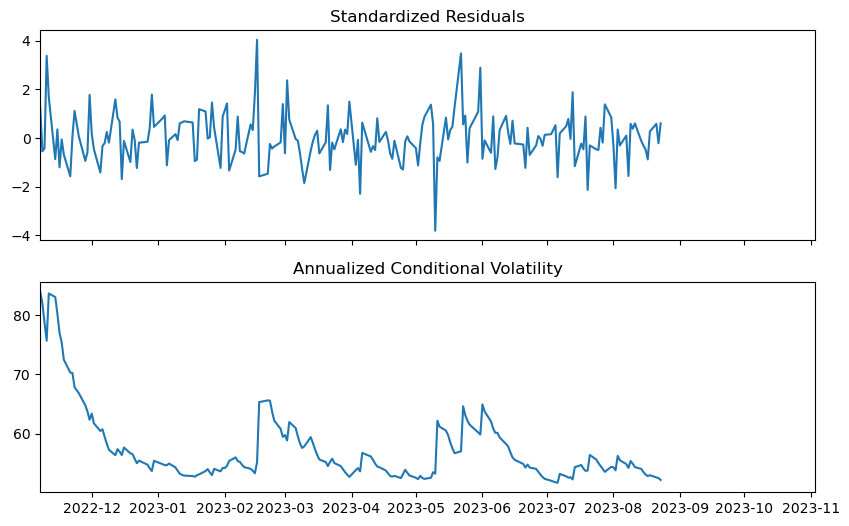

In [98]:
fig = res.plot(annualize='D')
plt.show()

In [99]:
idx_df = pdr.get_data_yahoo('SPY', period='1y')[['Close']]
print('stock_df',idx_df.shape)

returns = 100 * idx_df['Close'].pct_change().dropna()
model = arch_model(returns, vol='Garch')

res = model.fit(last_obs=split_date)

[*********************100%%**********************]  1 of 1 completed
stock_df (251, 1)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 223570668.6836732
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1213129596.3063524
Iteration:      3,   Func. Count:     21,   Neg. LLF: 373.56519352713053
Iteration:      4,   Func. Count:     27,   Neg. LLF: 275.8772081102876
Iteration:      5,   Func. Count:     33,   Neg. LLF: 277.5093089359299
Iteration:      6,   Func. Count:     39,   Neg. LLF: 277.3747177071903
Iteration:      7,   Func. Count:     45,   Neg. LLF: 276.670432633718
Iteration:      8,   Func. Count:     51,   Neg. LLF: 274.3448972320065
Iteration:      9,   Func. Count:     57,   Neg. LLF: 272.83105984426356
Iteration:     10,   Func. Count:     63,   Neg. LLF: 269.76977043922005
Iteration:     11,   Func. Count:     69,   Neg. LLF: 276.8862647069214
Iteration:     12,   Func. Count:     75,   Neg. LLF: 266.3009290526106
Iteration:     13,   Func. Count:     80,   Ne

In [100]:
print(res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -265.138
Distribution:                  Normal   AIC:                           538.277
Method:            Maximum Likelihood   BIC:                           551.450
                                        No. Observations:                  199
Date:                Sun, Nov 05 2023   Df Residuals:                      198
Time:                        13:39:22   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0794  5.927e-02      1.339      0.181 [-3.68

In [101]:
forecasts = res.forecast(horizon=10, start=today, method='simulation')
forecasts.variance[today:]

results_df['SPY_var_h.10'] = forecasts.variance[today:]['h.10']
results_df['SPY_mean_h.10'] = forecasts.mean[today:]['h.10']
results_df

,TWLO_var_h.10,TWLO_mean_h.10,SPY_var_h.10,SPY_mean_h.10
Date,,,,
2023-10-20,11.800067,0.175128,0.330106,0.079357
2023-10-23,11.686205,0.175128,0.329446,0.079357
2023-10-24,11.757733,0.175128,0.328797,0.079357
2023-10-25,11.895865,0.175128,0.328158,0.079357
2023-10-26,11.840022,0.175128,0.327529,0.079357
2023-10-27,11.784678,0.175128,0.326911,0.079357
2023-10-30,11.807840,0.175128,0.326303,0.079357
2023-10-31,11.711459,0.175128,0.325705,0.079357
2023-11-01,11.731933,0.175128,0.325116,0.079357


long_df: (22, 3)


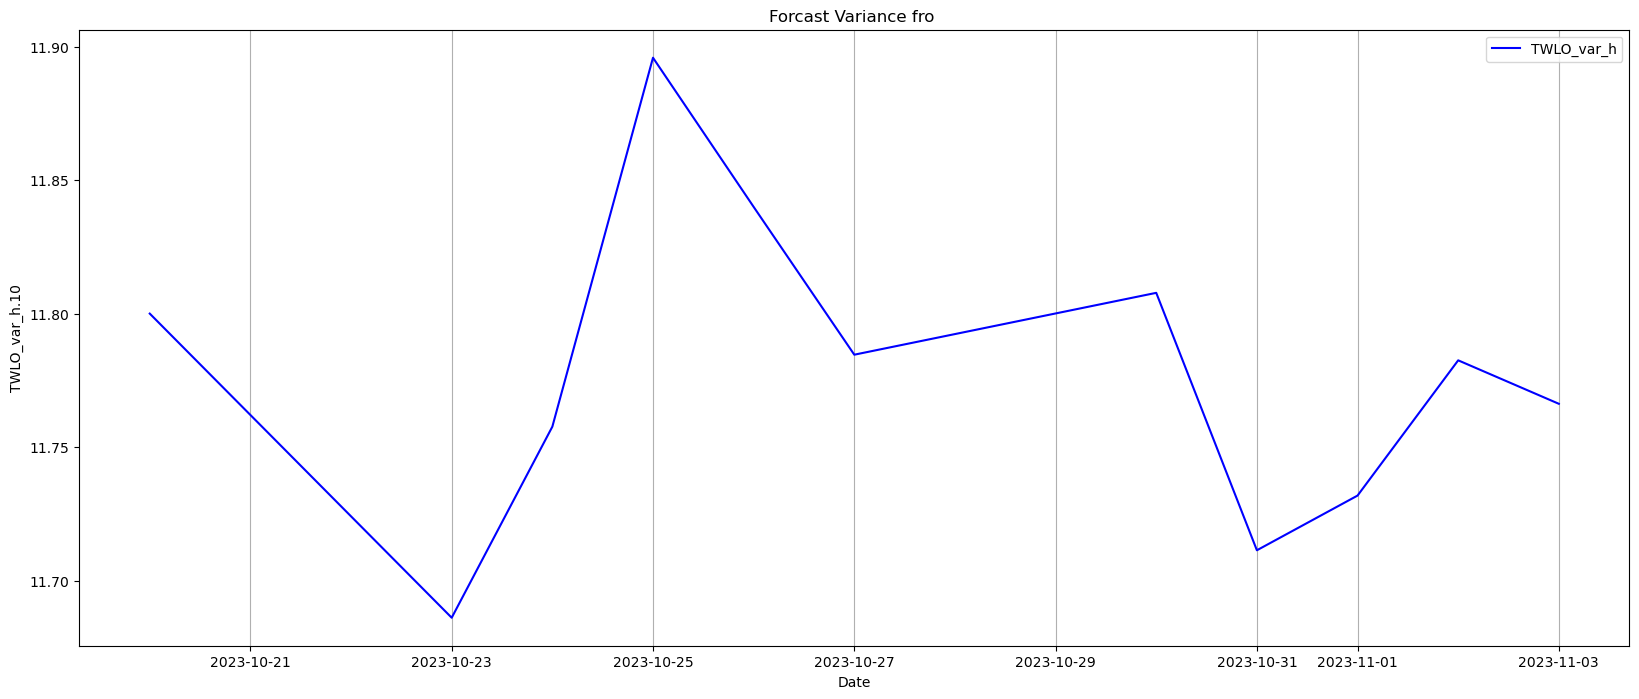

In [102]:
# Long 
long_df = results_df[['TWLO_var_h.10','SPY_var_h.10']].copy()
long_df.reset_index(inplace=True)
long_df = long_df.melt(id_vars=['Date'])
print('long_df:', long_df.shape)

# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

#g = sns.lineplot(x = 'Date', y = 'value', data=long_df, hue='variable')
g = sns.lineplot(x = 'Date', y = 'TWLO_var_h.10', data=results_df, label='TWLO_var_h', color='blue')
#g.set(xlim = (30,32))
plt.ticklabel_format(style='plain', axis='y')
ax.set(title='Forcast Variance fro ');

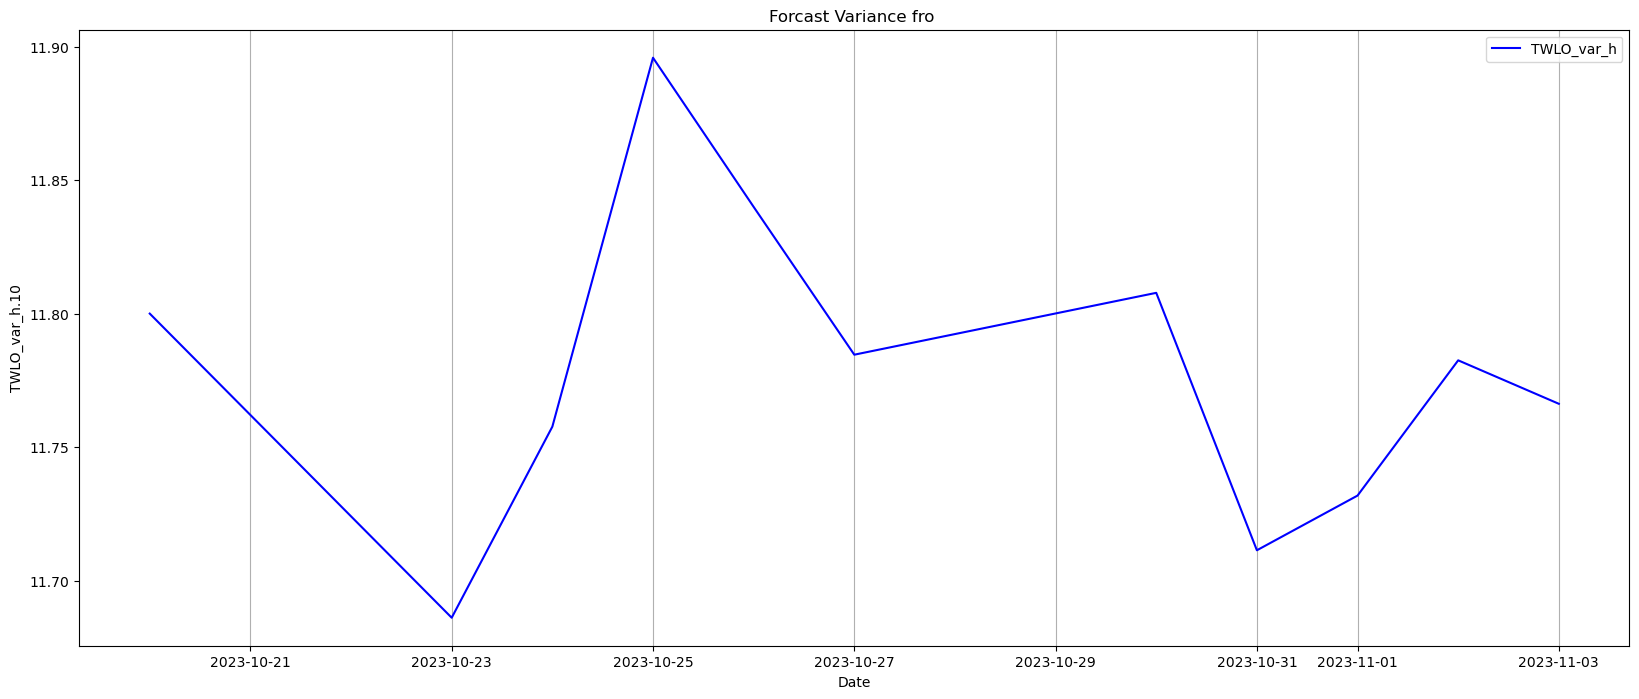

In [103]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

#g = sns.lineplot(x = 'Date', y = 'value', data=long_df, hue='variable')
g = sns.lineplot(x = 'Date', y = 'TWLO_var_h.10', data=results_df, label='TWLO_var_h', color='blue')
plt.ticklabel_format(style='plain', axis='y')
ax.set(title='Forcast Variance fro ');

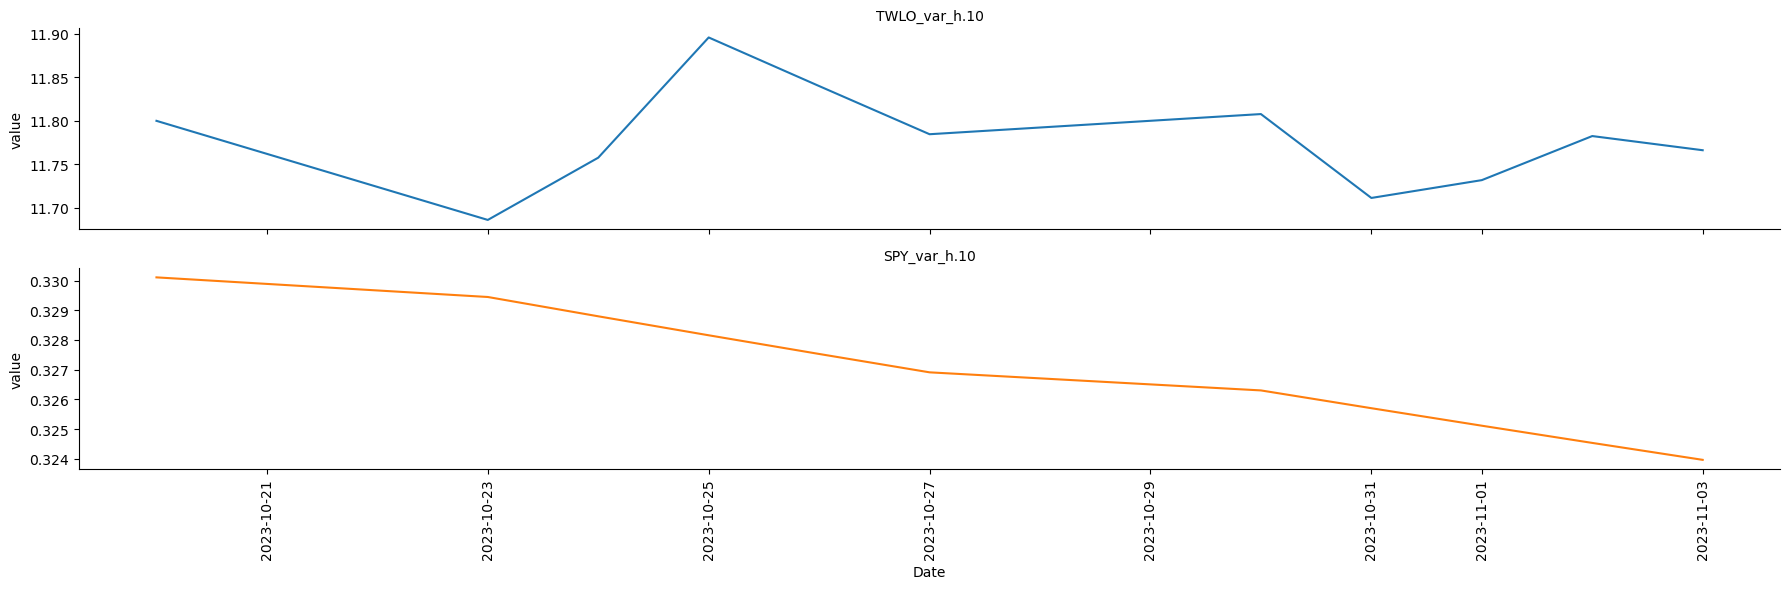

In [109]:
long_df = results_df[['TWLO_var_h.10','SPY_var_h.10']].copy()
long_df.reset_index(inplace=True)

long_df = long_df.melt(id_vars=['Date'])


# Graph
g = sns.FacetGrid(long_df, col='variable', hue='variable',
                  height=3, aspect=6,col_wrap=1, sharey=False)

g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.tick_params(axis='x', labelrotation=90) 
g.tight_layout()
g.map_dataframe(sns.lineplot, y="value", x="Date")

plt.show()